# Black hole rendering with SageMath

### Florentin Jaffredo

## Introduction

This notebook is a step-by-step implementation of a basic rendering engine in curved spacetime. The objective is to obtain a somewhat realistic image of an accretion disk around a black hole.

The technique consists in launching lightlike geodesics toward the past from a single point (the virtual camera), using the [geodesic integrator](http://doc.sagemath.org/html/en/reference/manifolds/sage/manifolds/differentiable/integrated_curve.html) of SageMath. To reduce computation time, the spacetime is assumed be spherical symmetric; this reduces the number of required geodesics to produce an image of $n_x\times n_y$ pixels from about $O\left(n_x n_y\right)$ to $O\left(\sqrt{n_x^2+n_y^2}\right)$.

This work relies heavily on the [SageManifolds Project](https://sagemanifolds.obspm.fr/). Advanced SageMath notions will also be used throughout this notebook, like Cython compilation and multithreading.

This notebook requires a version of SageMath at least equal to 9.0:


In [1]:
version()

'SageMath version 10.1, Release Date: 2023-08-20'

## Overview

The code is separated into 9 parts.

* Declaring the spacetime
* Launching a geodesic
* Launching a lot of geodesics!
* Figuring out where it intersects with the accretion disk
* Adding thickness to the disk
* Using black-body radiation and converting spectra to RGB
* First relativistic effect: Doppler effect
* Second relativistic effect: aberration (forward focalisation)
* Conclusion


### Configuration

This notebook can be quite ressource hungry to run. For that reason different configurations options are provided. It is recommended to start with the lowest one to check that everything works properly. You can of course adapt the number of CPUs to your needs.

**First configuration:** will run in less than a minute on a 4-core laptop. Produces tiny images with no details (no secondary image).

In [2]:
# n_cpu = 4 # 4 Go Ram minimum
# n_geod = 100
# nx, ny = 180, 90

**Second configuration:** will run in about 5 minutes on a workstation, produces a reasonably sized image:

In [3]:
n_cpu = 8 # 8 Go Ram minimum
n_geod = 1000
nx, ny = 720, 360

**Third configuration:** will run in 30 minutes on the Google Cloud Compute Engine. Produces a 4K image showing tiny details on the secondary disk images.

In [4]:
# n_cpu = 36 # 144 Go Ram minimum
# n_geod = 30000
# nx, ny = 4000, 2000

Additional preliminaries: display objects with $ \LaTeX $ where possible:

In [5]:
%display latex

## Declaring the spacetime

Let's start slow by declaring the spacetime we'll use for rendering: it is the ***Schwarzschild spacetime***.

It is important to use a coordinate system that is regular at the horizon. Here we use the *Eddington-Finkelstein coordinates*.

Let $m$ be the mass of the black hole (that we'll take equal to 2 later). 

We also add a restriction to ensure that nothing touches the central singularity, and we set the metric $g$.

In [6]:
M = Manifold(4, 'M', structure='Lorentzian')

In [7]:
C.<t, r, th, ph> = M.chart(r't r:(1,+oo) th:(0,pi):\theta ph:\phi')
C.coord_range()

t: (-oo, +oo); r: (1, +oo); th: (0, pi); ph: (-oo, +oo)

In [8]:
m = var('m')

In [9]:
g = M.metric()
g[0,0] = -(1 - 2*m/r)
g[0,1] = 2*m/r
g[1,1] = 1 + 2*m/r
g[2,2] = r^2
g[3,3] = (r*sin(th))^2
g[:]

[    2*m/r - 1         2*m/r             0             0]
[        2*m/r     2*m/r + 1             0             0]
[            0             0           r^2             0]
[            0             0             0 r^2*sin(th)^2]

In [10]:
g.display()

g = (2*m/r - 1) dt⊗dt + 2*m/r dt⊗dr + 2*m/r dr⊗dt + (2*m/r + 1) dr⊗dr + r^2 dth⊗dth + r^2*sin(th)^2 dph⊗dph

We also define a 3-dimensional Euclidean space $E$ to plot some results, using a map $\phi: M \rightarrow E$:

In [11]:
E.<x, y, z> = EuclideanSpace()
phi = M.diff_map(E, [r*sin(th)*cos(ph), r*sin(th)*sin(ph), r*cos(th)])
phi.display()

M → E^3
   (t, r, th, ph) ↦ (x, y, z) = (r*cos(ph)*sin(th), r*sin(ph)*sin(th), r*cos(th))

## Launching a geodesic

[Geodesic integration](http://doc.sagemath.org/html/en/reference/manifolds/sage/manifolds/differentiable/integrated_curve.html) was first implemented in SageMath in 2017 and perfected in 2018 to support fast integration and event handling (used to detect the singularity in our case).

To introduce the method, let's plot an orbit around a black hole.

To do that, we need to find a starting point $p$ as well as an inital velocity vector $v$. It can be quite troublesome to find a suitable one, but here is a free one:

In [12]:
p = M((0, 14.98, pi/2, 0))
Tp = M.tangent_space(p)
v = Tp((2, 0, 0.005, 0.05))
v = v / sqrt(-g.at(p)(v, v))

$v$ is defined as a member of the tangent space at $p$. The last line is used to normalize $v$ as a unit timelike vector.

Next is the definition of the geodesic. We need to pass a symbolic variable for the proper time (which will not be used). The starting point is deduced from the velocity vector (as the point where the velocity vector is defined).

In [13]:
tau = var('tau')
curve = M.integrated_geodesic(g, (tau, 0, 3000), v)

The integration should be very fast. Don't forget to give some numerical value to $m$ here.

In [14]:
sol = curve.solve(step = 1, method="ode_int", parameters_values={m: 2})
# sol = curve.solve(step = 1, parameters_values={m: 2})

Plotting the solution requires an interpolation. This is automatically done in the next line.

In [15]:
interp = curve.interpolate()

The following cell plots the result using the mapping we provided previously. We also add a grey sphere at $r_s = 2m = 4$ (the event horizon) to give a scale.

In [16]:
P = curve.plot_integrated(mapping=phi, color="red", thickness=2, plot_points=3000)
P += sage.plot.plot3d.shapes.Sphere(4, color='grey')
P

Graphics3d Object

You can see that it look nothing like an ellipse, as we are used to in classical celestial mechanics. At this step, you can try adding an angular momentum to the black hole--in other words going from Schwarzschild to Kerr--by setting a non-zero angular momentum in the definition of the manifold ($J=1$ works fine). When this is the case, the orbits are not even included in a plane. Don't forget to revert back your changes before proceeding to the next part.

## Launching a lot of geodesics!

Of course one geodesic is not enough for us, we'll need at least a few hundred of them.

Because we don't need to compute the equation again each time, we simply copy the previous declaration of the geodesic while changing the initial point and velocity.

It will be useful here to introduce the Python module `multiprocessing` and progress bars as widgets:

In [17]:
import multiprocessing
from ipywidgets import FloatProgress
from IPython.display import display

It wouldn't be a great idea to set "1 job = 1 geodesic integration". Indeed, that would mean copying the geodesic declaration a few hundred times, which would be quite slow. What is done instead is seperating geodesics into batches using the following function:

In [18]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

The number of batches per CPU in not very important. If set to 1, some CPUs may run faster than other ones and stay idle at the end. If too high, too much time will be spent copying the curve setting. I found 3 to be a good value.

In [19]:
n_batches_per_cpu = 3

We also redefine the previous geodesic to our new needs: fewer steps and the ability to check for chart boundaries when integrating. The $v$ in this case will not be used; it will always be overwritten before starting any integration.

In [20]:
curve = M.integrated_geodesic(g, (tau, 0, 200), v, across_charts=True)

When using `multiprocessing`, functions can only accept a single argument. To overcome this limitation, each argument will be a tuple (curve, start index, number of curves to integrate).

In [21]:
args = []
start_index = 0

for chunk in chunks(range(n_geod), n_geod//(n_batches_per_cpu*n_cpu)):
    args += [(loads(curve.dumps()), start_index, len(chunk))]
    start_index += len(chunk)

The next line prints the list of arguments. We can check that each of the 100 geodesics are correctly set. Our little trick allowed us to only define 13 geodesics (about 3 per core, as we wanted; note, the exact result here will depend on what you used for `n_cpu` at the beginning)

In [22]:
print(args[-1])
print(len(args))

(Integrated geodesic in the 4-dimensional Lorentzian manifold M, 984, 16)
25


Now comes a question: which vector can be used as the starting 4-velocity?

We need a past-oriented lightlike vector pointing toward the center but with a linearly increasing angle. The 3 space components are already imposed. The time component must then be chosen so that the total vector is lightlike.

Let $p$ be the initial point and $v$ the initial 4-velociy, with an unknown time coordinate $dt$ ($y$ depends on the angle, it is a known quantity).

In [23]:
dt, y, r0 = var('dt, y, r0')

In [24]:
p = M((0, r0, pi/2, 0))
Tp = M.tangent_space(p)
v = Tp((dt, -1, 0, y))

The norm of $v$ is currently given by:

In [25]:
g.at(p)(v, v)

r0^2*y^2 + dt^2*(2*m - r0)/r0 - 4*dt*m/r0 + (2*m + r0)/r0

We need to find $dt$ so that this expression is equal to 0 (lightlike condition). this is easy:

In [26]:
sol = g.at(p)(v, v).solve(dt)
sol

[dt == -(sqrt(-(2*m*r0 - r0^2)*y^2 + 1)*r0 - 2*m)/(2*m - r0), dt == (sqrt(-(2*m*r0 - r0^2)*y^2 + 1)*r0 + 2*m)/(2*m - r0)]

As expected, there are two solutions: one past-oriented and one future-oriented. In fact, in our case it does not matter, given that the Schwartzschild spacetime is static.

The next cell defines the function that will be called by `multiprocessing`. It starts by unpacking the arguments, setting an empty dictionary as the result, and defining the starting position.

The initial velocity is then overwritten using the formula above, the integration is performed, and the result is added to the dictionary.

In [27]:
def calc_some_geodesics(args):
    """
    Compute nb geodesics starting at index n0
    """
    curve, n0, nb = args
    res = {}
    r = 100
    posi = [0, r, pi/2, 0]
    p = M(posi)
    Tp = M.tangent_space(p)
    for i in range(n0, n0+nb):
        # starting vector
        dy = i*0.006/n_geod
        v = Tp([sol[0].rhs()(r0=r, y=dy, m=2).n(), -1, 0, dy])
        # overwrite the starting vector
        curve._initial_tangent_vector = v
        # integration with m=2
        curve.solve_across_charts(step=0.2, parameters_values={m:2})
        # copy and clear solution
        res[i] = (p.coord(), curve._solutions.copy())
        curve._solutions.clear()
    return res

`geo` will keep the numerical solutions. I like to see `pool` as a hole in which I can throw some jobs. `multiprocessing` will then magically do them for me using every resource available on the computer.

In [28]:
geo = {}
pool = multiprocessing.Pool(n_cpu)

# progress bar display
%display plain
f = FloatProgress(min=0, max=n_geod)
display(f)

for i, some_res in enumerate(pool.imap_unordered(calc_some_geodesics, args)): # do and wait
    # progress bar update
    f.value += len(some_res)
    # update result
    geo.update(some_res)

# clean exit
pool.close()
pool.join()

FloatProgress(value=0.0, max=1000.0)

If, for any reason, you don't want to use parallel computing, you can replace the previous cell with this one:

In [29]:
# geo = calc_some_geodesics((c, 0, n_geod))

We can now try to visualize those geodesics.
Next cell will plot 20 of them.

In [30]:
# add the sphere
P = sage.plot.plot3d.shapes.Sphere(4, color='grey')

# cycle through the solutions
for i in range(0, n_geod, 5*n_geod/100):    
    # set solution
    curve._solutions = geo[i][1]
    # do interpolation
    interp = curve.interpolate()
    # plot the curve
    P += curve.plot_integrated(mapping=phi, color=["red"], thickness=2, plot_points=150, 
                               label_axes=False, across_charts=True)

# show the result    
P

Graphics3d Object

We can see that some fall inside the black hole toward the singularity. That's not an issue because the integration is automaticaly stopped when the geodesic leaves the chart domain defined in part 1.

## Intersection with the accretion disk

Time to transform those simulated light-rays into an image. To do this, we first need to compute the intersection between each geodesic and the accretion disk.

For this example, the disk spans from $r=8$ to $r=50$, and is tilted by an angle $\alpha = - \frac{\pi}{20}$.

In [31]:
disk_min = 12
disk_max = 50
alpha = -pi/20

Let's plot the disk on top of the last figure.

(We cheat a little bit here and use a flattened torus.)

In [32]:
D = sage.plot.plot3d.shapes.Torus((disk_min+disk_max)/2,
                                  (disk_min-disk_max)/2).scale(1,1,0.01).rotateY(-pi/20)

In [33]:
P + D

Graphics3d Object

The same but tilted on the X-axis by an angle $\beta=\frac{\pi}{3}$. As explained earlier, the final image will be obtained by computing for each pixel : 

* Which geodesic best describes the light-ray
* Which angle $\beta$ at which the disk should be tilted
* The intersection between the disk and that geodesic


In [34]:
P + D.rotateX(pi/3)

Graphics3d Object

The geodesics are formatted in a strange way because of the solver used. The next line makes it easier to use. `geo` is now a list of list of coordinates (and not a dictionary of strange things).

In [35]:
geo = [list(geo[i][1].values())[0][0][1].tolist() for i in range(len(geo))]

To detect the intersection between the disk and a geodesic, the only solution is to parse the list of successive coordinates. This is done in the following function.

For each point of the curve, two rotations are performed (manually for speed purposes) before checking the point coordinates.

In [36]:
def intersection(curve, alpha, beta):
    """
    Return True if the curve intersect the disk comprised between dmin and dmax
    tilted of angles alpha and beta
    """
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):
        # done in 3 lines for speed consideration
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # conversion to cartesian:
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta) 
        # rotation around the X-axis:
        y2, z2 = y2*cos(beta)-z2*sin(beta), z2*cos(beta)+y2*sin(beta)  
        # rotation around the Y-axis:
        x2, z2 = x2*cos(alpha)-z2*sin(alpha), z2*cos(alpha)+x2*sin(alpha)       
        if z!=z2:           # needed to prevent a division by zero next line
            t = z/(z-z2)    # if 0<=t<1 then the curve intersect the disk between the points i and i-1
            if t>=0 and t<1 and curve[i][2]>disk_min and curve[i][2]<disk_max: #check coordinates
                return True
        x, y, z = x2, y2, z2
    return False

The only problem with this function is the speed at which it operates. Let's try it on an example:

In [37]:
%time intersection(geo[28], alpha=pi/5, beta=0)

CPU times: user 1.72 s, sys: 8.6 ms, total: 1.72 s
Wall time: 1.73 s


False

On my computer, it takes more than one second. You can imagine that if this must be done for each pixel, we would have to wait for days for even a single image.
By the way, you can argue that everything this function does could be done more efficiently, using for example `numpy` matrix operations. That's true, but in the next parts we'll do more inside the loop than just `return True`.

The solution: compile this function!

Sage lets us use Cython quite easily, so let's do that.

In [38]:
%%cython
from libc.math cimport cos, sin
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef intersection(list curve, float alpha, float beta, float dmin, float dmax):
    """
    Return True if the curve intersect the disk comprised between dmin and dmax
    tilted of angles alpha and beta
    """
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                return True
        x, y, z = x2, y2, z2
    return False

In [39]:
%time intersection(geo[28], pi/5, 0, disk_min, disk_max)

CPU times: user 75 µs, sys: 3 µs, total: 78 µs
Wall time: 80.8 µs


False

Boom!  
x10000 speedup in my case!

Time to automate the process and make an image. We'll once again use `multiprocessing`. One job this time will correspond to one row of pixels. This time we'll use `numpy`.
The result will be an array of RGB colors.

In [40]:
import numpy as np
data = np.zeros( (ny, nx, 3), dtype=float )

In [41]:
def render_row(x):
    """
    Render a single row of the image
    """
    res = np.zeros((ny,3))                  # result row in RGB format
    for y in range(ny):                     # for each pixel in the row
        beta = atan2(y-ny/2,x)              # beta angle 
        r = sqrt(x**2+(y-ny/2)**2)          # pixel distance to the center of the image
        ind_geo = int(r/400*n_geod*720/nx)  # index of the geodesic to use. values are obtained by trial and error.
        if ind_geo<n_geod:                  # don't bother if the index is too big.
            if intersection(geo[ind_geo], float(pi/20), float(beta), 
                            float(disk_min), float(disk_max)):
                res[ny-1-y,:] = [255, 0, 0] # red if intersects; black otherwise
    return x, res                           # also return the argument, which is not remembered otherwise

This time, it is very important to use the argument `maxtasksperchild` to kill the unused processes. This prevents a memory leak.

We enclose it inside a function because we'll be calling it multiple times.

In [42]:
def render():
    # display progress bar
    f = FloatProgress(min=0, max=nx)
    display(f)
    pool = multiprocessing.Pool(n_cpu, maxtasksperchild=int(10))
    for i, rows in enumerate(pool.imap_unordered(render_row, 
                                                 range(-nx/2, nx/2))): # do and wait
        
        # update progress bar
        f.value+=1
        # copy the result in the right place
        x, res = rows
        data[:, x+nx/2, :] = res 
    # clean exit
    pool.close()
    pool.join()

In [43]:
render()

FloatProgress(value=0.0, max=720.0)

The image used to be constructed from `data` via `scipy.misc.toimage`, but this function has been removed from SciPy 1.3 and higher versions (such as SciPy 1.5.2 used by SageMath 9.2). As a replacement, we employ the user-defined function `toimage` proposed in this [Stack Overflow post](https://stackoverflow.com/questions/57545125/attributeerror-module-scipy-misc-has-no-attribute-toimage); it is based on `PIL.Image`:

In [44]:
from PIL import Image

_errstr = "Mode is unknown or incompatible with input array shape."

def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)

def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tobytes())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tobytes())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tobytes())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tobytes())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tobytes())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tobytes())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tobytes()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tobytes()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tobytes()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

With the above definition of `toimage`, we get the actual image from `data`:

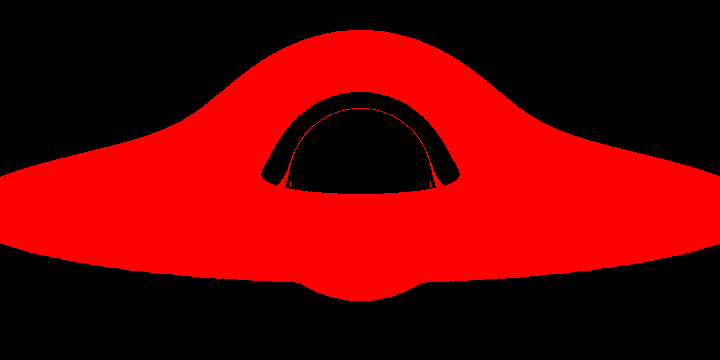

In [45]:
img1 = toimage(data)
img1

If you have seen the movie *Interstellar*, you will know that this looks a bit like a (monochrome) black hole, a very simple one for sure, but we'll improve it step by step in the following sections.

## Adding thickness to the disk

First we will be adding transpareny and thickness to the disk. For that, let's assume the disk is optically thin. This means light can only be added and never obstructed. What's more, the intensity will be proportional to the total length of emissive medium traversed.

This length depends on 2 factors: the profile of the disk and the angle $\theta$ between the disk and the light ray:

$\qquad d = \frac{f(r)}{sin(\theta)}$

The computation of the angle $\theta$ is not trival. The fastest way to obtain it is the perform a change of frame, which will locally (at a single point) give us a Minkowsky metric (orthonormal frame), in which angles are easy to compute.

To remind you, here is our metric:

In [46]:
%display latex
g[:]

[    2*m/r - 1         2*m/r             0             0]
[        2*m/r     2*m/r + 1             0             0]
[            0             0           r^2             0]
[            0             0             0 r^2*sin(th)^2]

Or for a point of the disk:

In [47]:
r0, phi = var('r_0, phi')
p = M((0, r0, pi/2, phi))
g.at(p)[:]

[(2*m - r_0)/r_0         2*m/r_0               0               0]
[        2*m/r_0 (2*m + r_0)/r_0               0               0]
[              0               0           r_0^2               0]
[              0               0               0           r_0^2]

We are not that far off. Some rescaling and mixing the first two lines should do the trick.

In [48]:
# default frame
fr = C.frame()

# create an automorphism field
aut = M.automorphism_field()

# some symbolic variables
a, b, c = var('a, b, c')

# let's try with the simplest matrix possible
aut.add_comp()[:] = [[a, 0, 0, 0], [b, c, 0, 0], [0, 0, 1/r0, 0], 
                     [0, 0, 0, 1/r0]] # only b is off-diagonal
fr2 = fr.new_frame(aut, 'f2')

In this new frame, the metric at $p$ looks like this:

In [49]:
g.at(p)[fr2.at(p), :]

[b^2*(2*m + r_0)/r_0 + a^2*(2*m - r_0)/r_0 + 4*a*b*m/r_0                       b*c*(2*m + r_0)/r_0 + 2*a*c*m/r_0                                                       0                                                       0]
[                      b*c*(2*m + r_0)/r_0 + 2*a*c*m/r_0                                     c^2*(2*m + r_0)/r_0                                                       0                                                       0]
[                                                      0                                                       0                                                       1                                                       0]
[                                                      0                                                       0                                                       0                                                       1]

This lets us find the values of $ a $, $ b $ and $ c $:

In [50]:
c = sqrt(r/(r+2*m))
a = sqrt(((r+2*m)/(r)))
b = -2*a*m/(2*m+r)

Let's check:

In [51]:
aut2 = M.automorphism_field() # new automorphism field
aut2.add_comp()[:] = [[a, 0, 0, 0], [b, c, 0, 0], [0, 0, 1/r, 0], [0, 0, 0, 1/(r*sin(th))]]
fr3 = fr.new_frame(aut2, 'f3')

In [52]:
g[fr3, :]

[-1  0  0  0]
[ 0  1  0  0]
[ 0  0  1  0]
[ 0  0  0  1]

Success!

We now have an orthonormal frame everywhere (this is only possible because this frame doesn't correspond to a system of coordinates; otherwise the spacetime would be flat).

Don't forget that vectors are contravariant tensors, so the components of the 4-velocity will be transformed by this matrix:

In [53]:
aut2.inverse()[:]

[      sqrt(r)/sqrt(2*m + r)                           0                           0                           0]
[2*m/(sqrt(2*m + r)*sqrt(r))       sqrt(2*m + r)/sqrt(r)                           0                           0]
[                          0                           0                           r                           0]
[                          0                           0                           0                   r*sin(th)]

The angle $\theta$ can now be computed using:  
$$\theta = \arctan\left(\frac{\overrightarrow{v}_{\bot}}{\overrightarrow{v}_{\parallel}}\right)$$  
Because this formula is using 3-vectors, it was indeed important to have been in an orthonormal frame.

We also need to perform rotation of the angles $\alpha$ and $\beta$ for the 4-velocity. In the next cell is a Cython version optimized for speed.

In [54]:
%%cython
from libc.math cimport cos, sin, sqrt

cpdef tuple spherical_to_xyz(float dr, float dtheta, float dphi, float r, 
                             float theta, float phi, float alpha, float beta):
    """
    Convert spherical coordinates to cartesian and apply the 
    two rotations at the same time.
    """
    cdef float dx, dy, dz
    cdef float ca, cb, ct, cp
    cdef float sa, sb, st, sp
    
    ca = cos(alpha); sa = sin(alpha)
    cb = cos(beta);  sb = sin(beta)
    ct = cos(theta); st = sin(theta)
    cp = cos(phi);   sp = sin(phi)
    
    dx = ((-cb*ct*sa - (sa*sb*sp - ca*cp)*st)*dr + 
          (r*cb*sa*st - (sa*sb*sp - ca*cp)*r*ct)*dtheta +
          (-(cp*sa*sb + ca*sp)*r*st)*dphi)
    
    dy = ((cb*sp*st - sb*ct)*dr +
          (r*ct*cb*sp + r*sb*st)*dtheta +
          (r*cp*cb*st)*dphi)
    
    dz = ((ca*cb*ct + (ca*sb*sp + cp*sa)*st)*dr +
          (-r*ca*cb*st+(ca*sb*sp + cp*sa)*r*ct)*dtheta +
          ((ca*cp*sb - sa*sp)*r*st)*dphi)
    
    return (dx, dy, dz)


cpdef tuple xyz_to_spherical(float dx, float dy, float dz, float x, 
                             float y, float z):
    """
    Convert cartesian back to spherical
    """
    cdef r, dr, dth, dph
    r = sqrt(x**2+y**2+z**2)
    dr = (x*dx+y*dy*z*dz)/r
    dth = ((x*z*dx+y*z*dy)/r**2/sqrt(x**2+y**2)-sqrt(x**2+y**2)*dz)/r**2
    dph = -y/(x**2+y**2)*dx+x/(x**2+y**2)*dy
    return (dr, dth, dph)

These formulas were obtained automatically by creating another chart and asking for the change of frames. Example:

In [55]:
def print_formulas(): # enclosed in a function to prevent altering the namespace
    alpha, beta = var('alpha, beta')
    spher.<r, theta, phi> = E.chart()
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta) # normal Spherical->Cartesian transformation
    y, z = y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)              # first rotation
    x, z = x*cos(alpha)-z*sin(alpha), z*cos(alpha)+x*sin(alpha)          # second rotation
    spher.transition_map(E.default_chart(), [x, y, z])
    print(list(E.changes_of_frame().values())[0][spher.frame(),:, spher])

print_formulas()

[    -cos(beta)*cos(theta)*sin(alpha) - (sin(alpha)*sin(beta)*sin(phi) - cos(alpha)*cos(phi))*sin(theta)  r*cos(beta)*sin(alpha)*sin(theta) - (sin(alpha)*sin(beta)*sin(phi) - cos(alpha)*cos(phi))*r*cos(theta)                                     -(cos(phi)*sin(alpha)*sin(beta) + cos(alpha)*sin(phi))*r*sin(theta)]
[                                                   cos(beta)*sin(phi)*sin(theta) - cos(theta)*sin(beta)                                                r*cos(beta)*cos(theta)*sin(phi) + r*sin(beta)*sin(theta)                                                                         r*cos(beta)*cos(phi)*sin(theta)]
[     cos(alpha)*cos(beta)*cos(theta) + (cos(alpha)*sin(beta)*sin(phi) + cos(phi)*sin(alpha))*sin(theta) -r*cos(alpha)*cos(beta)*sin(theta) + (cos(alpha)*sin(beta)*sin(phi) + cos(phi)*sin(alpha))*r*cos(theta)                                      (cos(alpha)*cos(phi)*sin(beta) - sin(alpha)*sin(phi))*r*sin(theta)]


<br>
<br>



The thickness of the disk will follow this profile, obtained from my high level understanding of black holes mechanics (i.e. it's mostly random, but looks nice)

In [56]:
%%cython
from libc.math cimport exp, erf

cpdef float profile(float x, float disk_min, float disk_max):
    cdef float y 
    # we really don't want negative values
    if x<disk_min or x>disk_max:
        return 0
    y = (exp(-(disk_min-20-x)**2/400)*(x-disk_min)**2*(disk_max-x)**2/10000 +
         exp(-(32-x)**2/70)/2*(x-disk_min)**2*(disk_max-x)**2/150000)
    return max(y, 0)

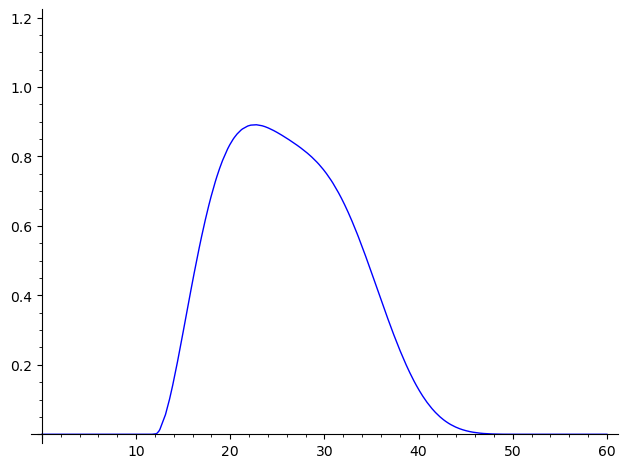

In [57]:
plot(lambda x, d1=disk_min, d2=disk_max: profile(x, d1, d2), 
     xmin=0, xmax=60, ymin=0, ymax=1.2)

We can now rewrite the function `intersection` taking everything into account. This time it directly returns an RGB value.

In [58]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float R, G, B
    cdef float dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th
    R, G, B = 0., 0., 0. # return values
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:        
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonorma frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt
                # angle theta
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))
                # thickness
                R += 40*profile(r, dmin, dmax)/sin(abs(th)) # arbitrary factor
        x, y, z = x2, y2, z2
    # clipping
    if R >= 255:
        R = 255
    return R, G, B

We also have to rewrite `render_row` to accept an RGB value.

In [59]:
def render_row(x):
    """
    Render a single row of the image
    """
    res = np.zeros((ny,3)) # result row in RGB format
    for y in range(ny):
        beta = atan2(y-ny/2,x)              # beta angle 
        r = sqrt(x**2+(y-ny/2)**2)          # pixel distance to the center of the image
        ind_geo = int(r/400*n_geod*720/nx)  # index of the geodesic to use. values are obtained by trial and error.
        if ind_geo<n_geod:                  # don't bother if the index is too big.
            res[ny-1-y,:] = intersection(geo[ind_geo], 2, float(pi/20), float(beta), 
                                         float(disk_min), float(disk_max))
    return x, res # also return the argument, which is not remembered otherwise

Let's try it:

FloatProgress(value=0.0, max=720.0)

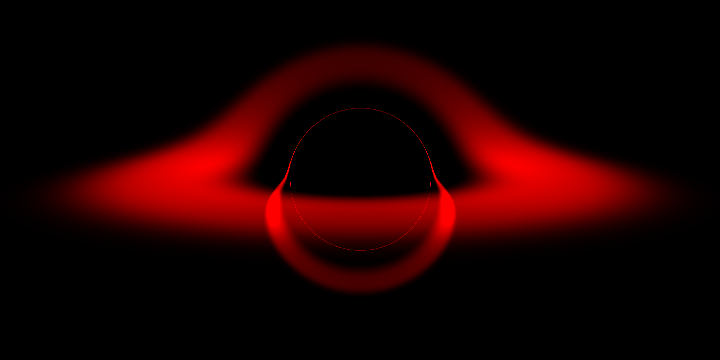

In [60]:
%display plain
data = np.zeros( (ny, nx, 3), dtype=float )
render()
img2 = toimage(data)
img2

Much more beautiful! 

But enough of red black holes, let's add real spectra into the mix.

## Black body spectrum

It's quite easy to associate a spectrum to each light ray, but it's also important to be able to convert it back to displayable colors.

This part shows how to do that, using the CIE standard XYZ function. This function should contain all information about a spectrum that is relevant to the human eye. They can then be converted to RGB for example. What's more, these functions are simply obtained by integrating the spectrum against a function. They are then linearly dependant on the spectrum.

To compute the XYZ functions, we first need the function that defines them. I got mine from here:  
http://www.cvrl.org/database/data/cmfs/ciexyzjv.csv

But because we are planning to add the Doppler effect, I added a lot of zeros at the beginning and the end to evntually encompass more wavelengths (I went from 5 to 3000 nm, instead of 380-780 for visible light).

In [61]:
from six.moves.urllib.request import urlretrieve  # valid for both Python 2 and Python 3
urlretrieve("http://www.cvrl.org/database/data/cmfs/ciexyzjv.csv", 
            "ciexyzjv.csv")
ciexyz = np.genfromtxt("ciexyzjv.csv", delimiter=",")

Here is what they look like. Y can be seen as the luminosity of a normalized spectrum (e.g. for the same light intensity, green will appear much brighter to the human eye than purple). The other two don't really have an interpretation.

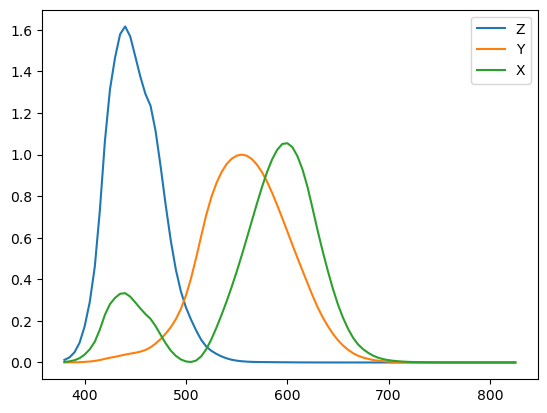

In [62]:
import matplotlib.pyplot as plt
plt.plot(ciexyz[:,0],ciexyz[:,3], label='Z')
plt.plot(ciexyz[:,0],ciexyz[:,2], label='Y')
plt.plot(ciexyz[:,0],ciexyz[:,1], label='X')
plt.legend(loc='best')
plt.show()

Next we need to compute the black body spectrum for a given temperature, using Planck's law.  
I already include the Doppler effect in the formula.

In [63]:
%%cython
from libc.math cimport exp

cpdef float blackbody(float nu, float T, float doppler):
    """
    Spectral power emmited at frequency nu by a black-body at 
    temperature T per square meter par steradian
    """
    cdef float h = 6.62e-34
    cdef float k = 1.38e-23
    cdef float c = 3e8
    cdef float h_sur_k = 4.79710144927536e-11
    return (2*h)*nu/c*nu/c*nu/(exp(h_sur_k*nu/doppler/T)-1)

In fact there is a small trick in the previous cell. Because of the exponent in the constants, it's fairly easy to overflow. That's why the $\nu^3/c^2$ is written this way.

Let's try at 10,000 K:

verbose 0 (3935: plot.py, generate_plot_points) WARNING: When plotting, failed to evaluate function at 170 points.
verbose 0 (3935: plot.py, generate_plot_points) Last error message: 'Unable to compute f(3000.0)'


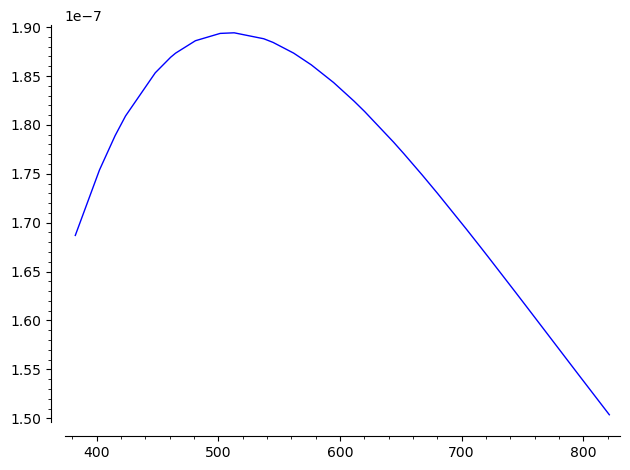

In [64]:
plot(spline([(l, blackbody(3e8/(l/1e9), 10000, 1)) for l in ciexyz[:,0]]), 
     xmin=5, xmax=3000)

Once again, we'll use Cython to convert a temperature into XYZ. Because XYZ depends linearly on the intensity, and not RGB, the conversion will be done in post-processing. Everything is redeclared in Cython for optimization (hence all the type declarations). Even the XYZ arrays are reloaded in this Cython environment.

In [65]:
%%cython
from __main__ import blackbody
from libc.math cimport exp
import numpy as np
cimport numpy as np
cimport cython

DTYPE = float
ctypedef np.float_t DTYPE_t

cdef np.float_t[:] cielamb
cdef np.float_t[:] ciex
cdef np.float_t[:] ciey
cdef np.float_t[:] ciez

def init_arrays():
    global cielamb, ciex, ciey, ciez
    cdef np.ndarray[np.float_t, ndim=2] ciexyz = np.genfromtxt('ciexyzjv.csv', delimiter=",")   
    cielamb = ciexyz[:, 0]
    ciex = ciexyz[:, 1]
    ciey = ciexyz[:, 2]
    ciez = ciexyz[:, 3]
    
init_arrays()

cpdef tuple temp_to_XYZ(float T, float doppler):
    cdef int nl = len(cielamb)
    cdef np.ndarray[np.float_t, ndim=1] sp = np.zeros(nl)
    cdef int i
    cdef float x, y, z
    for i in range(nl):
        sp[i] = blackbody(3e8/(cielamb[i]/1e9), T, doppler)
    x = np.dot(sp, ciex)
    y = np.dot(sp, ciey)
    z = np.dot(sp, ciez)
    return (x, y, z)

Let's convert it to RGB, using one of the many formulas, just to see how it looks:

In [66]:
def xyz_to_rgb(*args):
    # constants
    fact = 3e-8 # arbitrary
    gamma = 1/2.2
    mat = [[3.24047, -1.53715, -0.498835],
           [-0.96256, 1.8752, 0.041556],
           [0.055648, -0.204043, 1.057311]]
    # conversion
    r, g, b = np.dot(mat, np.transpose(args)/fact).tolist()
    # gamma correction and clipping
    r = min(1,max(0, r)**gamma)
    g = min(1,max(0, g)**gamma)
    b = min(1,max(0, b)**gamma)
    return r, g, b

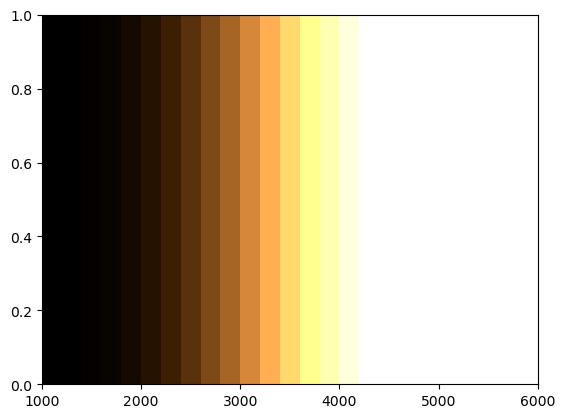

In [67]:
from matplotlib.patches import Rectangle
axes = plt.gca()
axes.set_xlim([1000, 6000])
for T in range(1000, 6000, 200):
    # plot a rectangle at a color obtained from the temperature
    axes.add_patch(Rectangle((T, 0), 200, 1, facecolor=xyz_to_rgb(*temp_to_XYZ(T, 1))))

With this formula, it becomes bright very quickly. Adjusting the $\gamma$ correction could help.

We can now add it to our black hole ray tracer:

In [68]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz
from __main__ import temp_to_XYZ

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float X, Y, Z
    cdef float X0, Y0, Z0
    cdef float dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th, doppler, factor,
    X, Y, Z = 0., 0., 0. # return values
    # 20 percent speed gain
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    # rotations
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonormal frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt
                # angle theta
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))   
                # thickness
                factor = profile(r, dmin, dmax)/sin(abs(th))
                # unused for now
                doppler = 1
                # added luminosity
                X0, Y0, Z0 = temp_to_XYZ(8000, doppler) # T=8000 because I decided
                # updating XYZ
                X += X0*factor
                Y += Y0*factor
                Z += Z0*factor
        x, y, z = x2, y2, z2
    return X, Y, Z

This time, after the render we still need to convert `data` from the XYZ format to RGB.

In [69]:
data = np.zeros( (ny, nx, 3), dtype=float )
render()

FloatProgress(value=0.0, max=720.0)

In [70]:
%%cython

import numpy as np
cimport numpy as np

cpdef np.ndarray[np.int, ndim=3] XYZ_to_RGB(np.ndarray[double, ndim=3] data):
    """
    Convert an 2d-array of XYZ values to RGB using a simple formula
    """
    cdef int ny = len(data)
    cdef int nx = len(data[0])
    cdef float x, y, z
    cdef int r, g, b
    cdef int i, j
    cdef np.ndarray[int, ndim=3] res = np.zeros((ny, nx, 3), dtype = np.int32)
    cdef float fact = 3e-8
    cdef float gamma = 1/1.2
    for i in range(ny):
        for j in range(nx):
            x, y, z = data[i, j, :]
            #fact = max(.002*y,1e-7)
            x, y, z = x/fact, y/fact, z/fact
            r = int(max(0,(3.240479*x -1.537150*y -0.498535*z))**(gamma))
            g = int(max(0,(-0.969256*x  +1.875992*y  +0.041556*z))**(gamma))
            b = int(max(0,(0.055648*x -0.204043*y  +1.057311*z))**(gamma))
            r = min(255, max(0, r))
            g = min(255, max(0, g))
            b = min(255, max(0, b))
            res[i, j, :] = r, g ,b
    return res

In [71]:
data_rgb = XYZ_to_RGB(data)

Let's plot the result again:

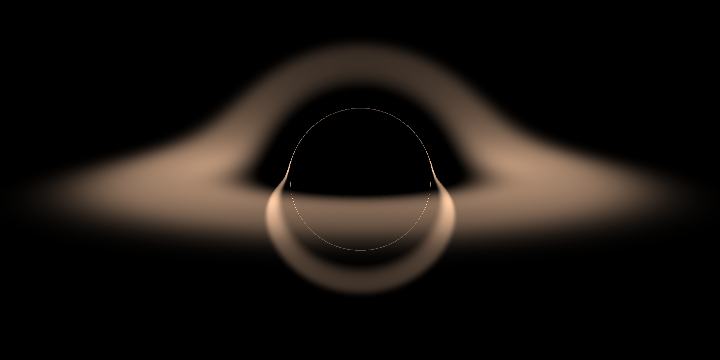

In [72]:
img3 = toimage(data_rgb)
img3

## First relativistic effect: Doppler effect

Everything has been so far done in such a way as to make this part easy. All we have to do is evalute the Doppler factor.

To compute the Doppler effect due to the rotation of the disk, we need to consider the interaction between to disk and the light ray in the orthonormal frame again. The goal is to use the general formula:

$$f_0 = \frac{f_s}{\gamma \left(1+\beta \cos(\theta)\right)}$$

To do that, we need to estimate $\beta$ and $\theta$.  
Let's first look at the equation of motion of a single particle, and impose circular motion: $dr=0$ and $\theta=\pi/2$

In [73]:
eqs = curve._equations_rhs[C]

In [74]:
dt, dr, dth, dph = curve._velocities

The 4 equations become (note: for technical reasons the equations below display $ dt $ as $ Dt $ and $ d\phi $ as $ Dph $; we could fix that but this is just an intermediate result so we don't bother):

In [75]:
%display latex
# d^2t/dtau^2 = 
eqs[0].subs({th: pi/2, dr: 0, dth: 0})

2*(Dph^2*m*r^3 - Dt^2*m^2)/r^3

In [76]:
# d^2r/dtau^2 = 
eqs[1].subs({th: pi/2, dr: 0, dth: 0})

-(2*Dph^2*m*r^3 - Dph^2*r^4 - 2*Dt^2*m^2 + Dt^2*m*r)/r^3

In [77]:
# d^2th/dtau^2 = 
eqs[2].subs({th: pi/2, dr: 0, dth: 0})

0

In [78]:
# d^2ph/dtau^2 = 
eqs[3].subs({th: pi/2, dr: 0, dth: 0})

0

In particular $d\phi$ is constant. We also solve the second equation for $dt$
(the sign depends on the directions of the rotations):

In [79]:
eqs[1].subs({th: pi/2, dr: 0, dth: 0}).solve(dt)

[Dt == -Dph*r*sqrt(r/m), Dt == Dph*r*sqrt(r/m)]

And so by reinjecting in the first equation $dt$ is constant, and so is $d\phi$, like in Newtonian gravity.  
Their values are obtained from the normalization condition.

In [80]:
p = M((0, r, pi/2, 0))
Tp = M.tangent_space(p)
v = Tp((r*sqrt(r/m)*dph, 0, 0, dph))

In [81]:
g.at(p)(v,v)

Dph^2*r^2 + Dph^2*(2*m - r)*r^2/m

In [82]:
(g.at(p)(v,v)==-1).solve(dph)

[Dph == -sqrt(-m/(3*m - r))/r, Dph == sqrt(-m/(3*m - r))/r]

As we can see, the smallest circular orbit can only by at $r=3m$, with:
<br>
<br>

$$ d\phi = \pm \frac{1}{r} \sqrt{\frac{m}{r-3m}} \qquad dt =\frac{1}{\sqrt{r}\sqrt{r-3m}} $$

We can see that:

If we switch to the orthonormal frame (just multiply $d\phi$ by $r$, as seen in the change of frame), we can see that:

$$\beta = \frac{v}{c} = \sqrt{\frac{m}{r-3m}}$$

To find $\theta$, we use the formula:

$$\theta = \arccos\left(\frac{\overrightarrow{v_1}\cdot \overrightarrow{v_2}}{||\overrightarrow{v_1}||\cdot||\overrightarrow{v_2}||}\right)$$

Finally, the gravitational redshift is easier. It is simply given by the ratio of first component of the 4-velocity in the orthonormal frame between the two ends of the geodesic.

In [83]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz
from __main__ import temp_to_XYZ

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    """
    Return True if the curve intersect the disk comprised between dmin 
    and dmax tilted of angles alpha and beta
    """
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float X, Y, Z
    cdef float X0, Y0, Z0
    cdef float dt, dt0, dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th, rho, doppler, beta_rel
    X, Y, Z = 0., 0., 0. # return values
    # 20 percent speed gain
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    dt0 = curve[1][1]-curve[0][1]
    # rotations
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonormal frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt
                # angle theta (used for thickness)
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))
                # thickness
                factor = profile(r, dmin, dmax)/sin(abs(th))
                # angle rho (used for Doppler effect)
                rho = acos(dphi/sqrt(dr**2+dtheta**2+dphi**2))
                # beta (used for Doppler effect)
                beta_rel = sqrt(m/(r-3*m))
                # Doppler factor
                doppler = 1
                doppler *= dt0/dt        # gravitational redshift
                doppler *= 1/(sqrt(1-beta_rel**2)*(1+beta_rel*cos(rho))) # rotation of the disk
                # added luminosity
                X0, Y0, Z0 = temp_to_XYZ(8000, doppler) # T=8000 because I decided
                # updating XYZ
                X += X0*factor
                Y += Y0*factor
                Z += Z0*factor
        x, y, z = x2, y2, z2
    return X, Y, Z

When plotted, this gives a nice asymmetry.

FloatProgress(value=0.0, max=720.0)

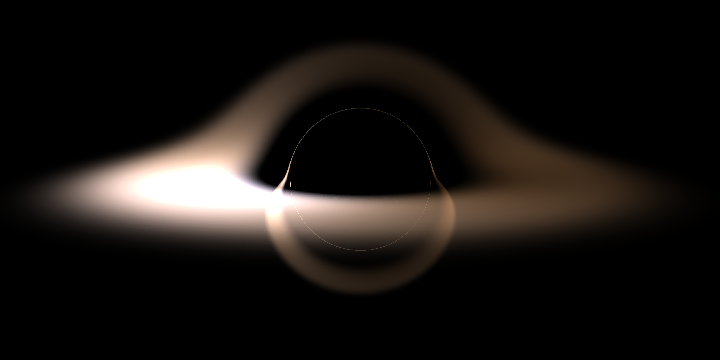

In [84]:
%display plain
data = np.zeros( (ny, nx, 3), dtype=float )
render()
data_rgb = XYZ_to_RGB(data)
img4 = toimage(data_rgb)
img4

## Second relativistic effect: aberration  (forward focalisation)

One last thing we didn't take into account is that a moving object that emits isotropic light at rest doesn't do so when in motion. The classical aberration formula reads:

$$\theta' = \arccos \left( \frac{\cos \theta -\beta}{1-\beta \cos \theta} \right)$$

In the rest frame, the number of light rays emanating from the object at an angle $\theta'$ is constant, equal to $\frac{dN}{d\theta'}$.

By using chain derivation, in the moving frame :

$$\frac{dN}{d\theta} = \frac{dN}{d\theta'} \frac{d\theta'}{d\theta}$$

As we can see, the number of rays per unit angle is multiplied by $\frac{d\theta'}{d\theta}$. Let's plot this function for multiple values of $\beta$.

In [85]:
beta = var('beta')

In [86]:
thp = acos((cos(th)-beta)/(1-beta*cos(th)))

In [87]:
%display latex
diff(thp,th)

-((beta - cos(th))*beta*sin(th)/(beta*cos(th) - 1)^2 + sin(th)/(beta*cos(th) - 1))/sqrt(-(beta - cos(th))^2/(beta*cos(th) - 1)^2 + 1)

In [88]:
aberration = abs(diff(thp,th)) # abs needed if we want negative angles

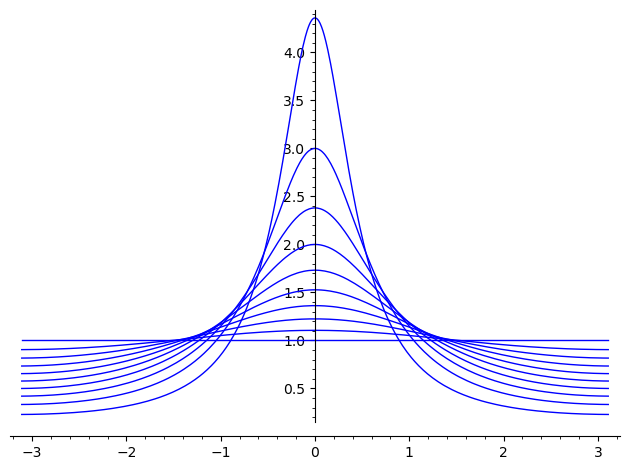

In [89]:
P = plot(aberration.subs(beta=0.), [-pi*.99,pi*.99])
for i in range(1,10):
    P += plot(aberration.subs({beta: 0.1*i}), [-pi*.99,pi*.99])
P.plot()

As we can see, the effect does focus rays toward the direction of motion. One can also check that the integral does not depend on $\beta$.

This is a fast cython implementation:

In [90]:
%%cython
from libc.math cimport cos, sin ,sqrt

cpdef float focalisation_factor(float th, float beta):
    # uses an other expression stricly equal, but faster to compute.
    return (cos(th)*(cos(th)+beta)+sin(th)**2)/\
        (sin(th)**2*sqrt(1-beta**2)+1/sqrt(1-beta**2)*(beta+cos(th))**2)

Finally, this is the final code for the intersection: 

In [91]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz
from __main__ import temp_to_XYZ
from __main__ import focalisation_factor

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float X, Y, Z
    cdef float X0, Y0, Z0
    cdef float dt, dt0, dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th, rho, doppler, beta_rel
    X, Y, Z = 0., 0., 0. # return values
    # 20 percent speed gain
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    dt0 = curve[1][1]-curve[0][1]
    # rotations
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]          
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonormal frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt          
                # angle theta (used for thickness)
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))
                # thickness
                factor = profile(r, dmin, dmax)/sin(abs(th))
                # angle rho (used for Doppler effect)
                rho = acos(dphi/sqrt(dr**2+dtheta**2+dphi**2))
                # beta (used for Doppler effect and focalisation)
                beta_rel = sqrt(m/(r-3*m))
                # Doppler factor
                doppler = 1
                doppler *= dt0/dt        # gravitational redshift
                doppler *= 1/(sqrt(1-beta_rel**2)*(1+beta_rel*cos(rho))) # rotation of the disk
                # added luminosity
                X0, Y0, Z0 = temp_to_XYZ(8000, doppler) # T=8000 because I decided
                # focalisation
                factor *= focalisation_factor(rho, beta_rel)
                # updating XYZ
                X += X0*factor
                Y += Y0*factor
                Z += Z0*factor
        x, y, z = x2, y2, z2
    return X, Y, Z

And this is the final rendering:

FloatProgress(value=0.0, max=720.0)

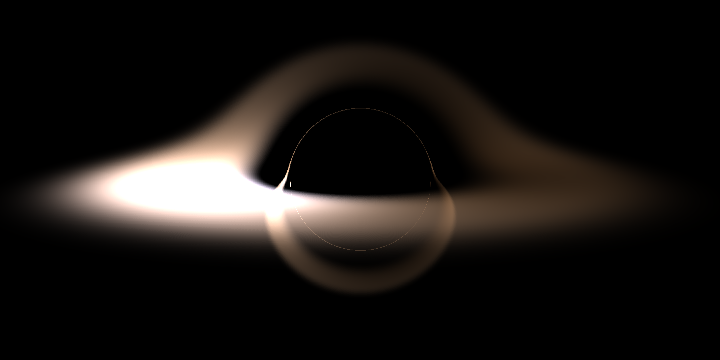

In [92]:
%display plain
data = np.zeros( (ny, nx, 3), dtype=float )
render()
data_rgb = XYZ_to_RGB(data)
img5 = toimage(data_rgb)
# img5.save("my_home_made_black_hole.png") # uncomment to save
img5

The difference with the previous image seems small, but that's only because the translation to RGB introduces luminosity clipping. In fact, the white area is twice as bright in the new picture.

## Conclusion

Here is a small recap of all the steps we went through:

### Geometric image:

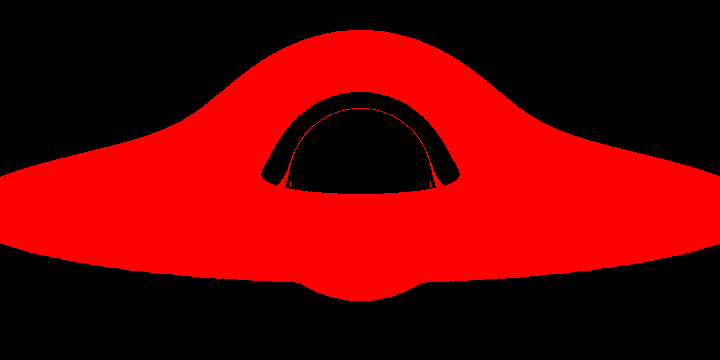

In [93]:
img1

### Disk thickness:

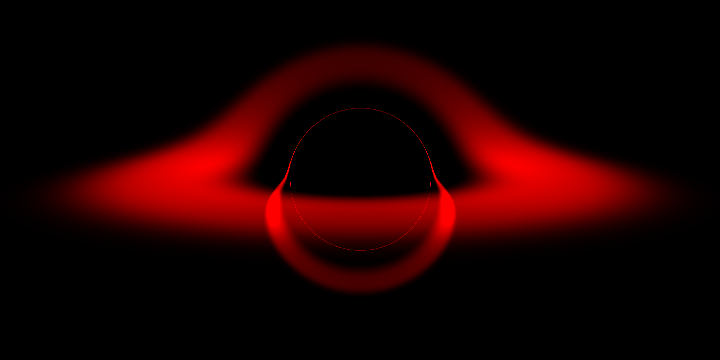

In [94]:
img2

### Black body object:

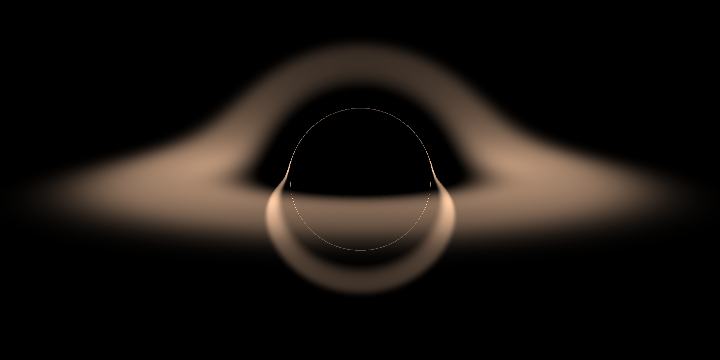

In [95]:
img3

### Doppler effect added:

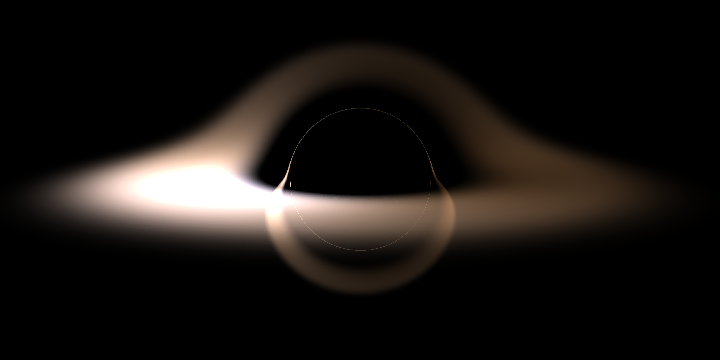

In [96]:
img4

### Relativistic aberration added:

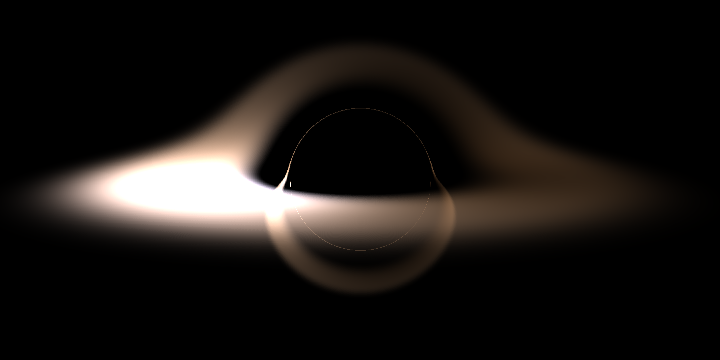

In [97]:
img5